In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [2]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
^C


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

In [ ]:
!mkdir skin-cancer-mnist-ham10000
!mv HAM10000* skin-cancer-mnist-ham10000
!mv hmnist* skin-cancer-mnist-ham10000

In [2]:
df = pd.read_csv("skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
label_map = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'nv': 4,
    'mel': 5,
    'vasc': 6
}
df['label'] = df['dx'].map(label_map)

base_dir = "skin-cancer-mnist-ham10000"

def find_image_path(image_id):
    part1 = os.path.join(base_dir, "HAM10000_images_part_1", f"{image_id}.jpg")
    part2 = os.path.join(base_dir, "HAM10000_images_part_2", f"{image_id}.jpg")
    
    if os.path.exists(part1):
        return part1
    elif os.path.exists(part2):
        return part2
    else:
        raise FileNotFoundError(f"Image {image_id}.jpg not found in either folder!")

df['image_path'] = df['image_id'].apply(find_image_path)

In [4]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0
    return image, label

In [7]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['image_path'].values,
                                        train_df['label'].values))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(2000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((test_df['image_path'].values,
                                       test_df['label'].values))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
class_names = [
    "Actinic Keratoses / Intraepithelial Carcinoma",
    "Basal Cell Carcinoma",
    "Benign Keratosis-like Lesion",
    "Dermatofibroma",
    "Melanocytic Nevus",
    "Melanoma",
    "Vascular Lesion"
]

2025-11-16 09:29:59.265408: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


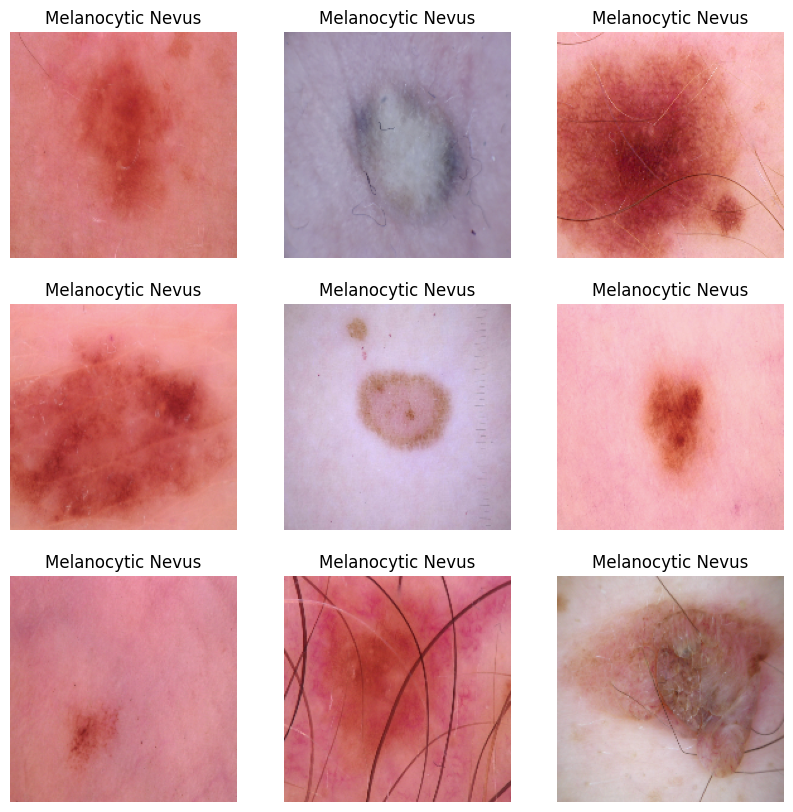

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Plot normalized image correctly
        plt.imshow(images[i].numpy())
        
        # Convert label Tensor → int
        label = int(labels[i].numpy())
        plt.title(class_names[label])
        plt.axis("off")

In [10]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:


### Your code goes here

# Number of target labels are 9
target_labels = 7

model = models.Sequential([
	layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
	layers.MaxPooling2D(),
	layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
	layers.MaxPooling2D(),
	layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
	layers.MaxPooling2D(),
	layers.Flatten(),
	layers.Dense(128, activation=tf.nn.relu),
	layers.Dense(target_labels)
])



In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
%%time
epochs = 20
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs
)
# Trains model

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.6638 - loss: 1.0161 - val_accuracy: 0.6700 - val_loss: 0.9103
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - accuracy: 0.6861 - loss: 0.8802 - val_accuracy: 0.6865 - val_loss: 0.9883
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.7034 - loss: 0.8254 - val_accuracy: 0.6975 - val_loss: 0.9322
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.7156 - loss: 0.7926 - val_accuracy: 0.7254 - val_loss: 0.7576
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.7350 - loss: 0.7270 - val_accuracy: 0.7134 - val_loss: 0.7778
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.7483 - loss: 0.6841 - val_accuracy: 0.7274 - val_loss: 0.7720
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.7637 - loss: 0.6489 - val_accuracy: 0.7179 - val_loss: 0.7512
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.7795 - loss: 0

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,968,631 (45.66 MB)

 Trainable params: 3,989,543 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,088 (30.44 MB)

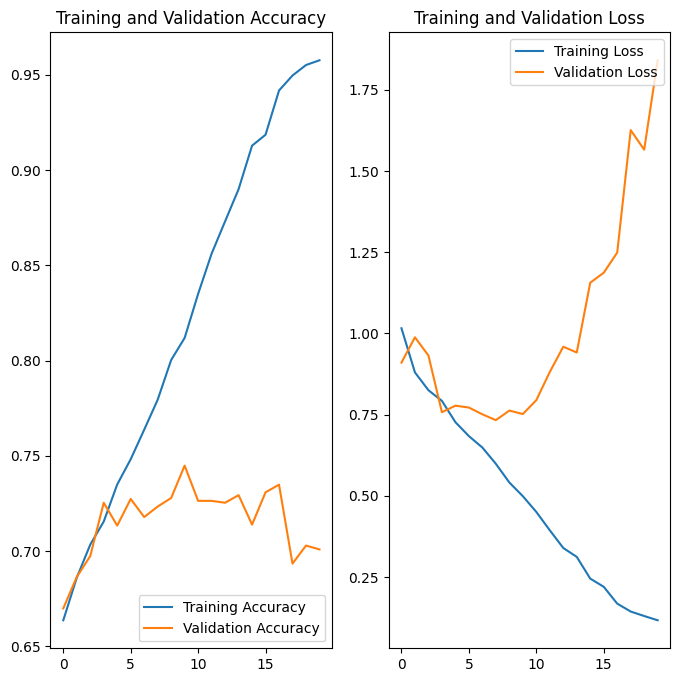

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
augmentation_data = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.10)
])

2025-11-16 09:47:00.698505: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


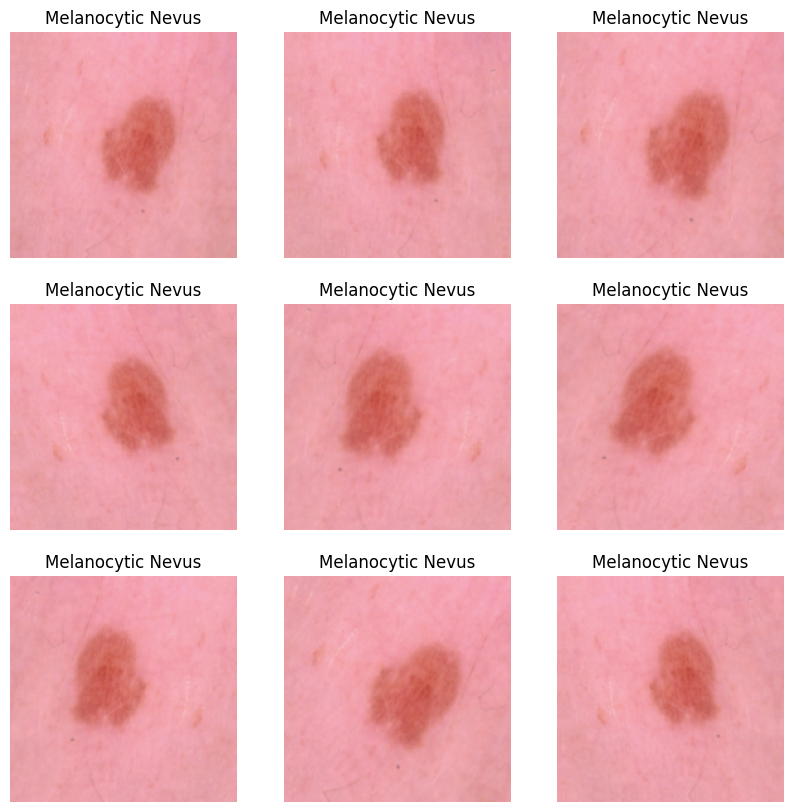

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy())
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [ ]:

lesions_df[['Label']].value_counts()

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [ ]:

round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

